In [6]:
import numpy  as np
import pandas as pd

import itertools
import random
import math  
import copy

import pandas_profiling

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

# Supporting functions from scikit-learn
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# for text processing
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Set a seed for replication
SEED = 1  # Use this anywhere a stochastic function allows you to set a seed

In [7]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx")
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

# Quick look at the data

In [8]:
df_learn.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 47 columns):
Unnamed: 0            3330 non-null int64
closeDay1             3215 non-null float64
offerPrice            3330 non-null float64
rf                    3057 non-null object
egc                   3330 non-null bool
html                  3330 non-null bool
patRatio              2055 non-null float64
city                  3329 non-null object
issuer                3330 non-null object
highTech              3330 non-null bool
age                   3148 non-null float64
exchange              3330 non-null object
year                  3330 non-null int64
industryFF5           3330 non-null object
industryFF12          3330 non-null object
industryFF48          3330 non-null object
nUnderwriters         3330 non-null int64
sharesOfferedPerc     3068 non-null float64
totalProceeds         3330 non-null int64
manager               3330 non-null object
investmentReceived    1830 non-null fl

**Comments**: We observe that there 47 columns out of which 39 are numeric/bool and 8 are text type. We also notice that there are some missing data in many fields. 

Now we look at the detailed profile of the dataFrame using pandas profiling. (The report is provided in HTML along with the submission. Observations related to the report are given below).

In [10]:
#file.profile_report()
profile = pandas_profiling.ProfileReport(df_learn)
#profile.to_file(outputfile='learn_data_profile_report.html')

**Observations from the profile report**

* Presence of missing values (Either drop or process the missig fileds)
* High correlation among 5 fields (May be ignored or Use PCA to reduce the dimentionality)
* Different scales, ranging from 0 to 1e9. (Need to normalize the data)
* Missing outcome: offerPrice(3.5%) and closeDay1(3.5%). Since there is no outcome, it may not be useful to use this data, may be dropped.
* Only 22% of the companies are marked emerging growth companies. (Possibility of bias?)
* Most of the companies are listed in NASDAQ(2368), followed by NYSE(895)
* Data is present from 1996 to 2018 (More data in the late 90s, but data is well spread across years)
* Five fields that are skewed (totalProceeds, InvestmentReceived, commonEquity1, totalRevenue, nPatents)
* 19 fileds out of 47 have missing entries. Highest missing entries in investmentReceived(45%) followed by nExecutives, priorFinancing, nVCs, patRatio, managementFee(32.9%) in descending order

In [ ]:
# Profile report for the prediction data
profile = pandas_profiling.ProfileReport(df_predict)
profile.to_file(outputfile='predict_data_profile_report.html')

In [11]:
df_learn['exchange'].value_counts()

NASDQ    2368
NYSE      895
AMEX       67
Name: exchange, dtype: int64

In [12]:
df_learn['industryFF5'].value_counts()

Business Equipment, Telephone and Television Transmission                                         1122
Other                                                                                              898
Healthcare, Medical Equipment, and Drugs                                                           621
Consumer Durables, NonDurables, Wholesale, Retail, and Some Services (Laundries, Repair Shops)     393
Manufacturing, Energy, and Utilities                                                               296
Name: industryFF5, dtype: int64

In [13]:
df_learn['industryFF12'].value_counts().head()

Business Equipment -- Computers, Software, and Electronic Equipment    945
Healthcare, Medical Equipment, and Drugs                               621
Finance                                                                483
Other                                                                  462
Wholesale, Retail, and Some Services (Laundries, Repair Shops)         271
Name: industryFF12, dtype: int64

In [14]:
df_learn['industryFF48'].value_counts().head()

Business Services          845
Pharmaceutical Products    409
Trading                    221
Electronic Equipment       190
Retail                     158
Name: industryFF48, dtype: int64

**Comments**: Will probably need to only keep 1 of these, maybe FF12?


In [15]:
df_learn = df_learn.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

**Comments**: Age is the age of the firm. Should replace mising values by the mean? Are the zeros indicating new firms?

In [16]:
print(df_learn['age'].mean())
print(df_learn['age'].mode())

16.184561626429478
0    3.0
dtype: float64


In [18]:
len([w for w in df_learn['age'] if w>100])

53

**Comments**: Is it possible to have so much old companies?

In [20]:
print(df_learn['blueSky'].median(), df_learn['blueSky'].mean())

10000.0 12916.115884115885


**Comments**: Should do something with *blue sky* missing value: need to decide if really useful and, if it is, how to fill it. mean, median or mean between 1sr and 3rd quarter

# Text pre-process on Risk Factor

In [34]:
# Get English Stopwords from NLTK & Extend the stop word list
SW = stopwords.words('english')
SW.append('risk')
SW.append('factors')


In [35]:
#looks how many percent of risk facor are NaN values
df_learn['rf'].isna().sum()/len(df_learn['rf'])

0.08198198198198198

In [36]:
#file them with a blank
df_learn['rf'] = df_learn['rf'].fillna('')

In [37]:
# Define a custom function to clean punctuation from  given text
def clean_punctuation(txt):
    return str(txt).replace(",", " ").replace(".", " ").replace(":", " ").replace(";", " ").replace("?", " ").replace("!", " ").replace("\\", " ")


In [38]:
# Apply the function to clean the rf column
df_learn['rf'] = df_learn['rf'].apply(clean_punctuation)    
df_learn['rf'].head(1)

0    RISK FACTORS You should carefully consider the...
Name: rf, dtype: object

In [40]:
# Define a custom function to clean some given text
def clean_re(txt):
    txt = re.sub("[+]", " ", txt)
    txt = re.sub("[&]", " ", txt)
    txt = re.sub("\s \s", " ", txt)
    txt = re.sub("\s \s \s", " ", txt)
    return txt

In [41]:
# Apply clean_re() to all features
df_learn['rf'] = df_learn['rf'].apply(clean_re)    
df_learn['rf'].head(1)

0    RISK FACTORS You should carefully consider the...
Name: rf, dtype: object

In [42]:
# Define custom function to remove stopwords
def clean_sw(txt):
    li = list(txt.lower().split(" "))
    txt = [word for word in li if word not in SW]
    return ' '.join(txt)

In [43]:
# Apply function to remove stopwords
df_learn['rf'] = df_learn['rf'].apply(clean_sw)    
df_learn['rf'].head(1)

0    carefully consider following information conta...
Name: rf, dtype: object

In [45]:
# Define custom function to wrap simple_preprocess() from gensim
def sp(txt):
    return simple_preprocess(txt)

In [46]:
# Apply simple_preprocess() to all features
df_learn['rf'] = df_learn['rf'].apply(sp)    
df_learn['rf'].head(1)

0    [carefully, consider, following, information, ...
Name: rf, dtype: object

In [47]:
#nltk.download('wordnet') #downloading wordnet to use lemmatizer
lmtz=nltk.stem.WordNetLemmatizer()
# Write a lemmatization function based on nltk.stem.WordNetLemmatizer()
def lemmatiz(txt):
    return [lmtz.lemmatize(mot) for mot in txt]

In [48]:
# Apply lemmatize_text() to all features  
df_learn['rf'] = df_learn['rf'].apply(lemmatiz)    
df_learn['rf'].head(1)

0    [carefully, consider, following, information, ...
Name: rf, dtype: object

# Preprocess of data


In [21]:
data = copy.copy(df_learn)

In [22]:
data['age'].fillna(data['age'].median(), inplace=True)

In [23]:
data['blueSky'].fillna(data['blueSky'].median(), inplace=True)

We decide to drop the data corresponding to missing or negative values of 'closeDay1' as this feature is very important and so replacing missing values may lead to huge misinterpretation. Moreover it corresponds to only 3.5% of the data


In [49]:
data.dropna(subset=["closeDay1"], inplace=True)
data.dropna(subset=["offerPrice"], inplace=True)

In [56]:
data=data.reset_index()

#data.profile_report()

Referring to the profile report generated, attached as HTML along with submission.

We can see that some features are highly correlated, so we will use PCA to remove the redundant features.

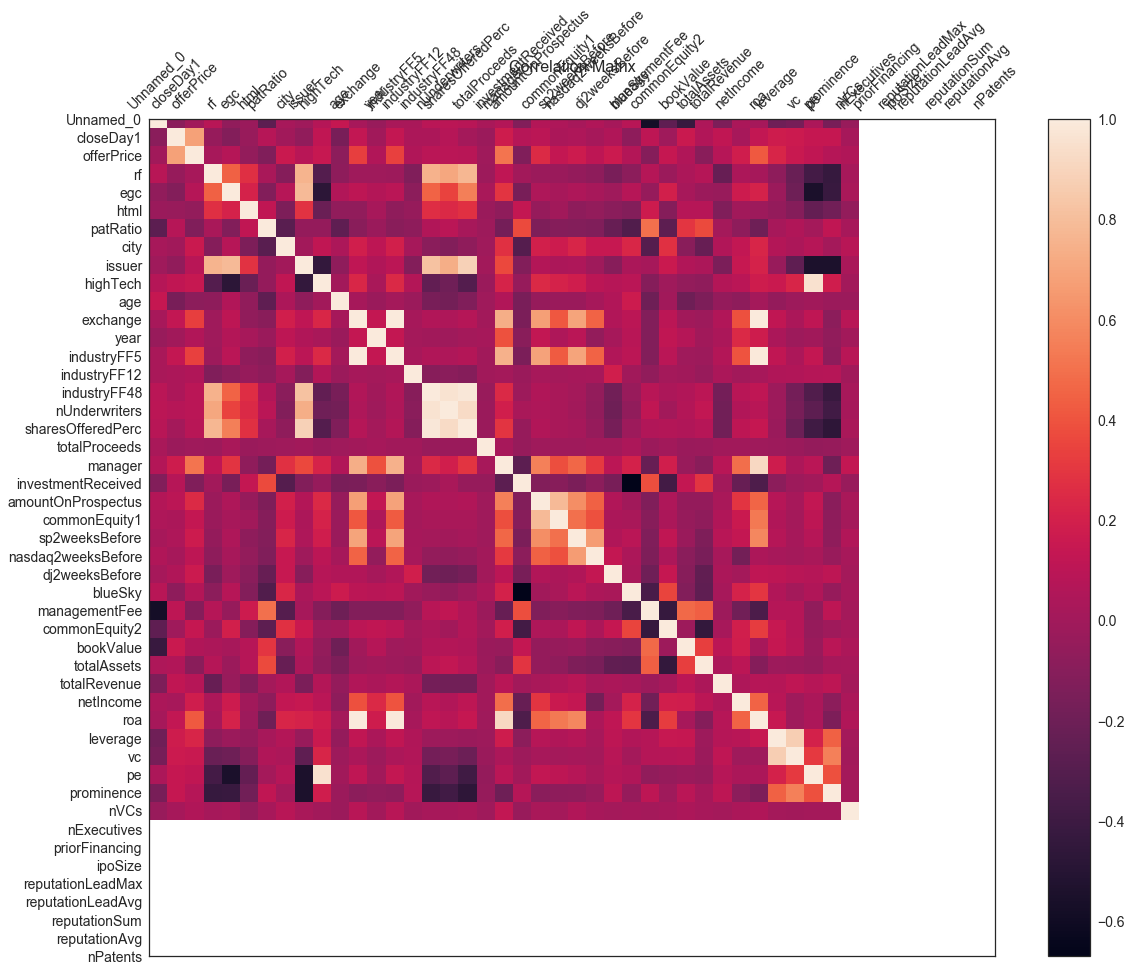

In [26]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);




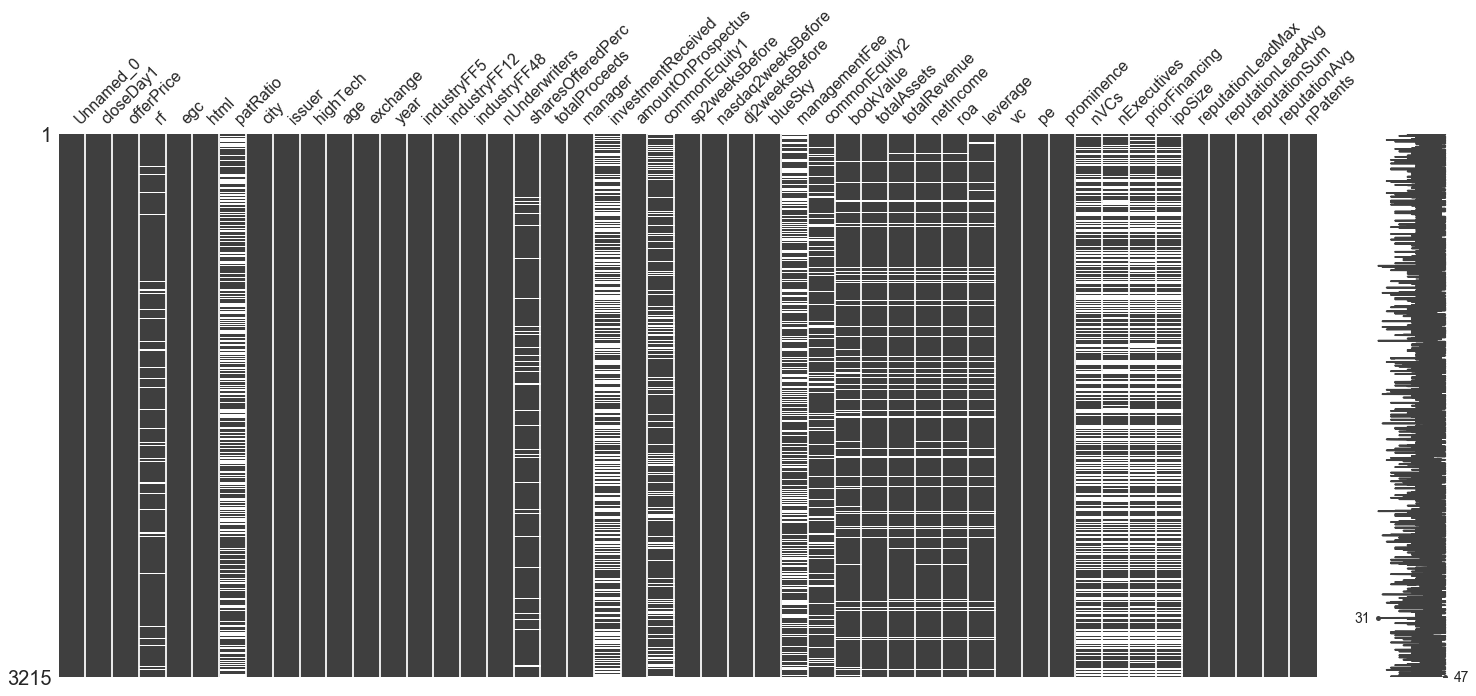

In [27]:
import missingno as msno
msno.matrix(data)

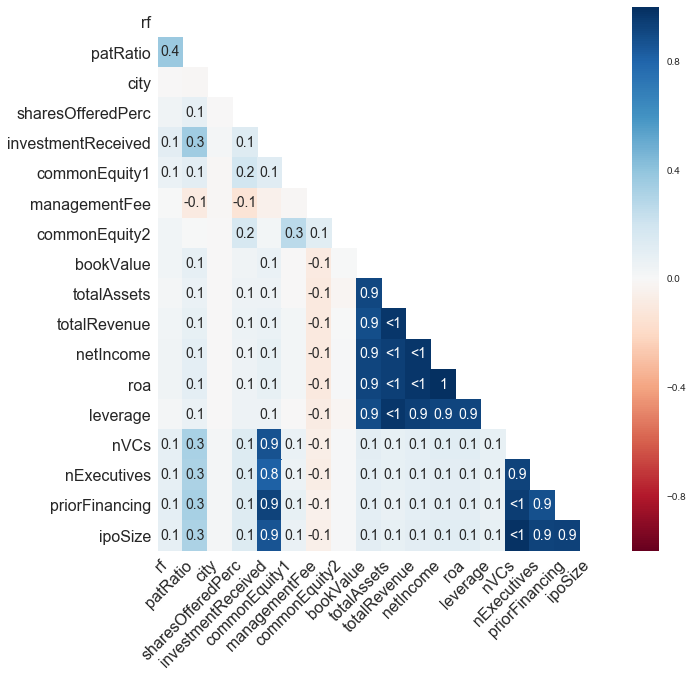

In [28]:
incomplete = data.columns[data.isnull().any()].tolist()
msno.heatmap(data[incomplete], figsize=(10,10))

In [45]:
data.insert(3,"raisingPrice", 0, True)

In [44]:
data=data.drop("raisingPrice", axis=1)


In [65]:
data.head(35)

,index,Unnamed_0,closeDay1,offerPrice,raisingPrice,rf,egc,html,patRatio,city,...,prominence,nVCs,nExecutives,priorFinancing,ipoSize,reputationLeadMax,reputationLeadAvg,reputationSum,reputationAvg,nPatents
0,0,974,35.5625,14.0,1,RISK FACTORS You should carefully consider the...,False,False,0.492063,SAN JOSE,...,1,5.0,5.0,64190.0,68114956.0,9.001,9.0010,106.014,7.572429,1
1,1,2585,20.0000,18.0,1,risk factors an investment in our common stock...,False,True,NaN,CONWAY,...,0,NaN,NaN,NaN,NaN,7.001,7.0010,19.003,4.750750,0
2,2,1936,26.1500,21.0,1,risk factors investing in our common stock inv...,False,True,NaN,BOISE,...,0,3.0,15.0,615284.0,247058826.0,9.001,8.7510,29.004,3.625500,77
3,3,842,13.8125,12.0,1,RISK FACTORS You should carefully consider the...,False,False,0.000000,SANTA CLARA,...,0,6.0,14.0,18682.0,26640000.0,9.001,9.0010,81.508,7.409818,3
4,4,2026,18.1500,12.5,1,risk factors investing in our common stock inv...,True,True,0.588391,WATERTOWN,...,1,14.0,17.0,114399.8,50000000.0,7.501,7.2510,14.502,3.625500,0
5,5,2896,14.0000,15.0,0,risk factors an investment in our classa commo...,True,True,NaN,SAN JOSE,...,0,NaN,NaN,NaN,NaN,8.501,8.5010,8.501,2.125250,0
6,6,2681,12.0000,12.0,0,risk factors investing in our classa common st...,False,True,NaN,FAIRPORT,...,0,NaN,NaN,NaN,NaN,0.000,0.0000,19.003,2.714714,0
7,7,1662,9.0000,11.0,0,Risk Factors ---------------------------------...,False,False,NaN,ROCKVILLE,...,0,1.0,6.0,NaN,60500000.0,8.001,8.0010,59.507,7.438375,0
8,8,371,17.0000,13.0,1,risk factors you should carefully consider the...,False,True,0.375000,REDWOOD CITY,...,1,12.0,14.0,99999.5,139100000.0,9.001,9.0010,43.006,8.601200,18
9,9,1528,13.1000,10.0,1,risk factors an investment in our common stock...,False,True,0.571429,ENFIELD,...,0,3.0,9.0,6378.0,123000000.0,9.001,4.5005,30.004,4.286286,0


In [64]:
for i in range (len(data['closeDay1'])):
    if data['closeDay1'][i]> data['offerPrice'][i]:
        data["raisingPrice"][i]= 1 
    else:
        data["raisingPrice"][i]= 0 
    
    


In [1]:
y = np.array(data['raisingPrice'])

NameError: name 'np' is not defined